In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import isnan

sns.set()

In [44]:
output_file = 'results/Ozone/results_final'

total_metrics = pd.read_csv(f'{output_file}.csv')

#total_metrics = pd.concat((total_metrics, pd.read_csv(f'{output_file_2}.csv')))
total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(len)
#total_metrics["selection_params_residual"] = total_metrics.selection_params_residual.fillna(False)

In [45]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT'})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[total_metrics.selection_name=='TSL', 'model_name'] = 'TSL'
total_metrics.loc[total_metrics.selection_name=='TimeSelectionLayerConstant', 'model_name'] = 'TSL*'
#total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.selection_params_residual), 'model_name'] = 'TSLRes'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})

In [ ]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col]
grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False).mean()
best_index = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name', 'selection_params_residual'], dropna=False).root_mean_squared_error_valid.idxmin()].index

total_metrics_indexed = total_metrics.set_index(['dataset', 'selection_name', 'model_name',*model_params])

best_by_year = total_metrics_indexed.loc[best_index, ['root_mean_squared_error', 'mean_absolute_error', 'dataset_params_test_year', 'features', 'selected_features']].reset_index()

best_by_year[best_by_year.dataset_params_test_year>2005].groupby(['dataset', 'model_name'], dropna=False).mean().reset_index().pivot(index = 'dataset', columns='model_name', values='root_mean_squared_error')#.to_latex()

<Figure size 1440x1440 with 0 Axes>

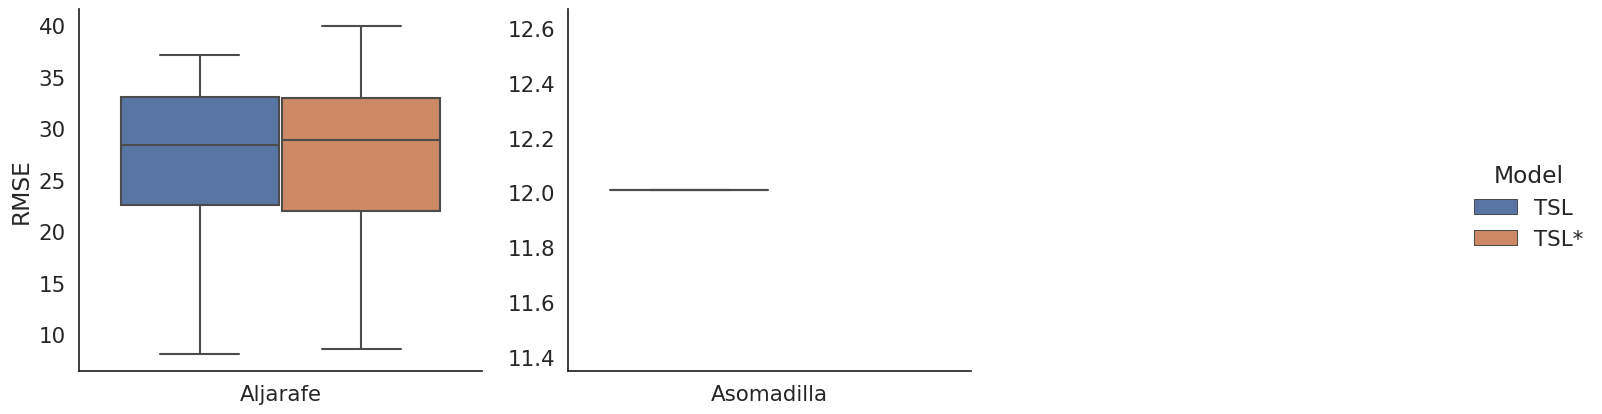

In [47]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 1440x1440 with 0 Axes>

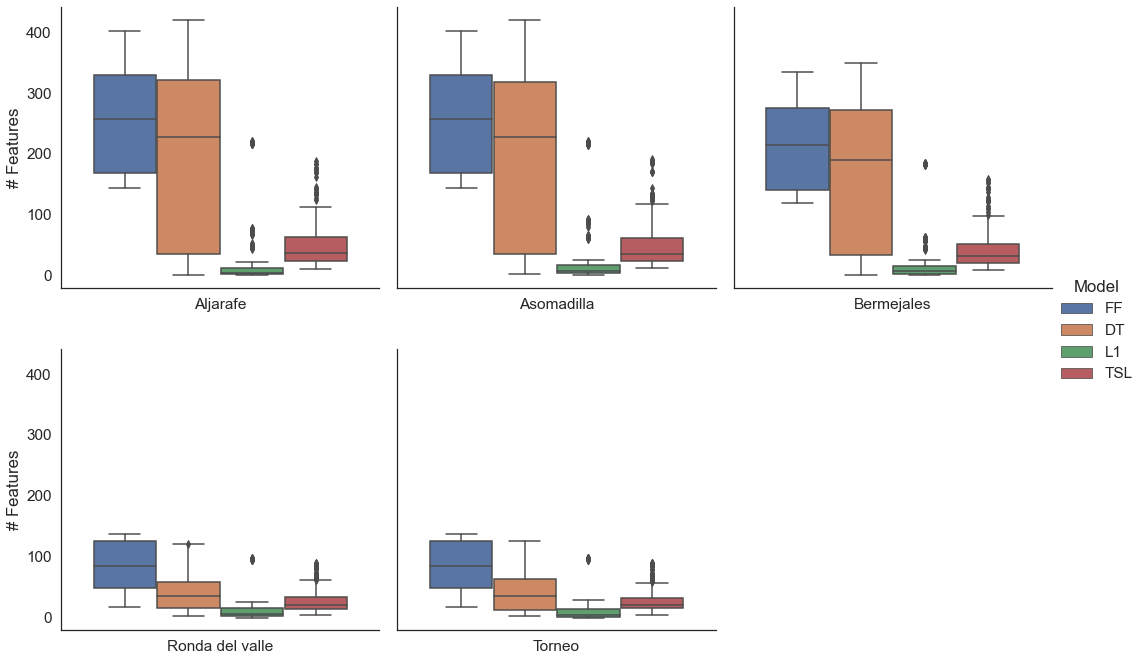

In [10]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics[(total_metrics.dataset_params_test_year>2005)], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

0.15040650406504066
0.09183673469387756
0.09795918367346938
0.15217391304347827
0.14492753623188406


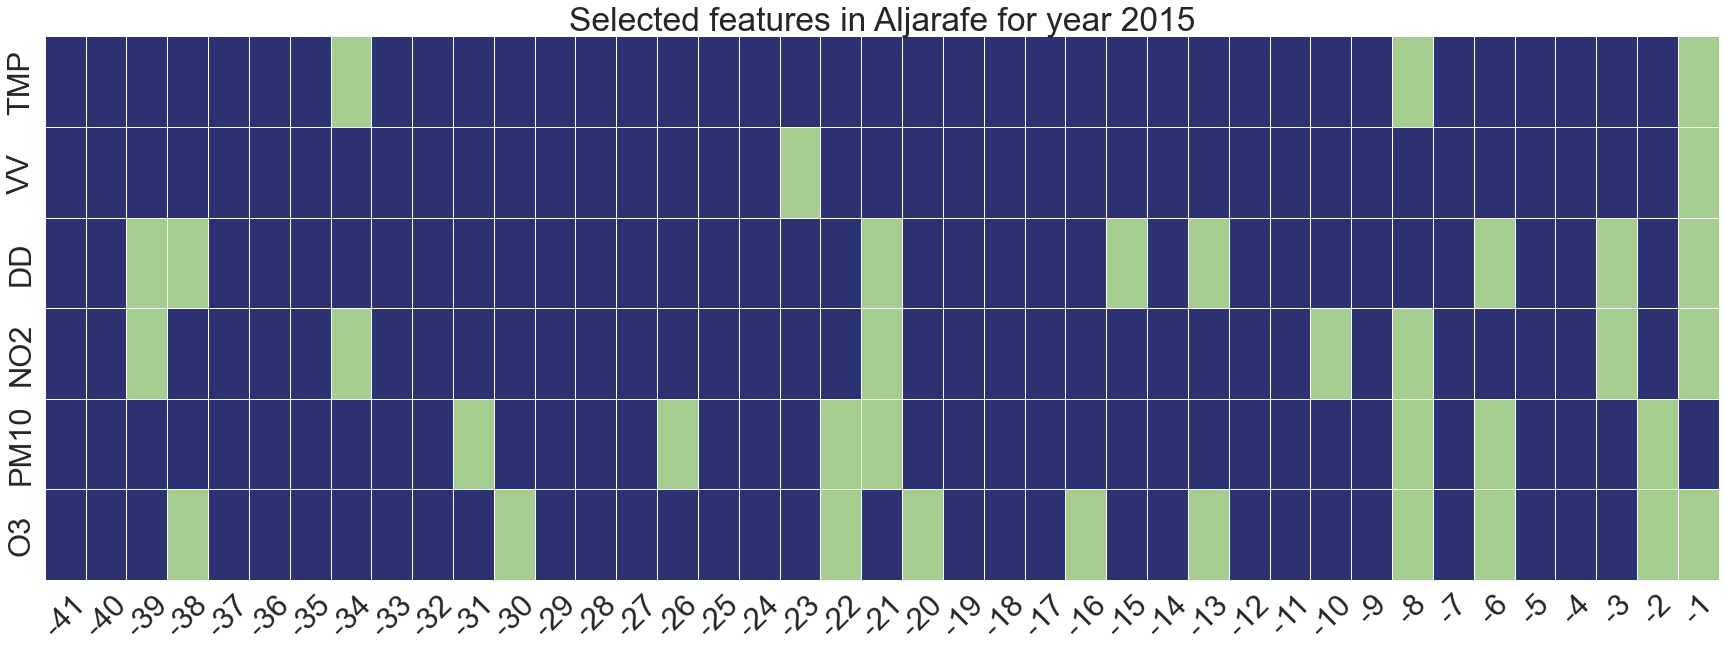

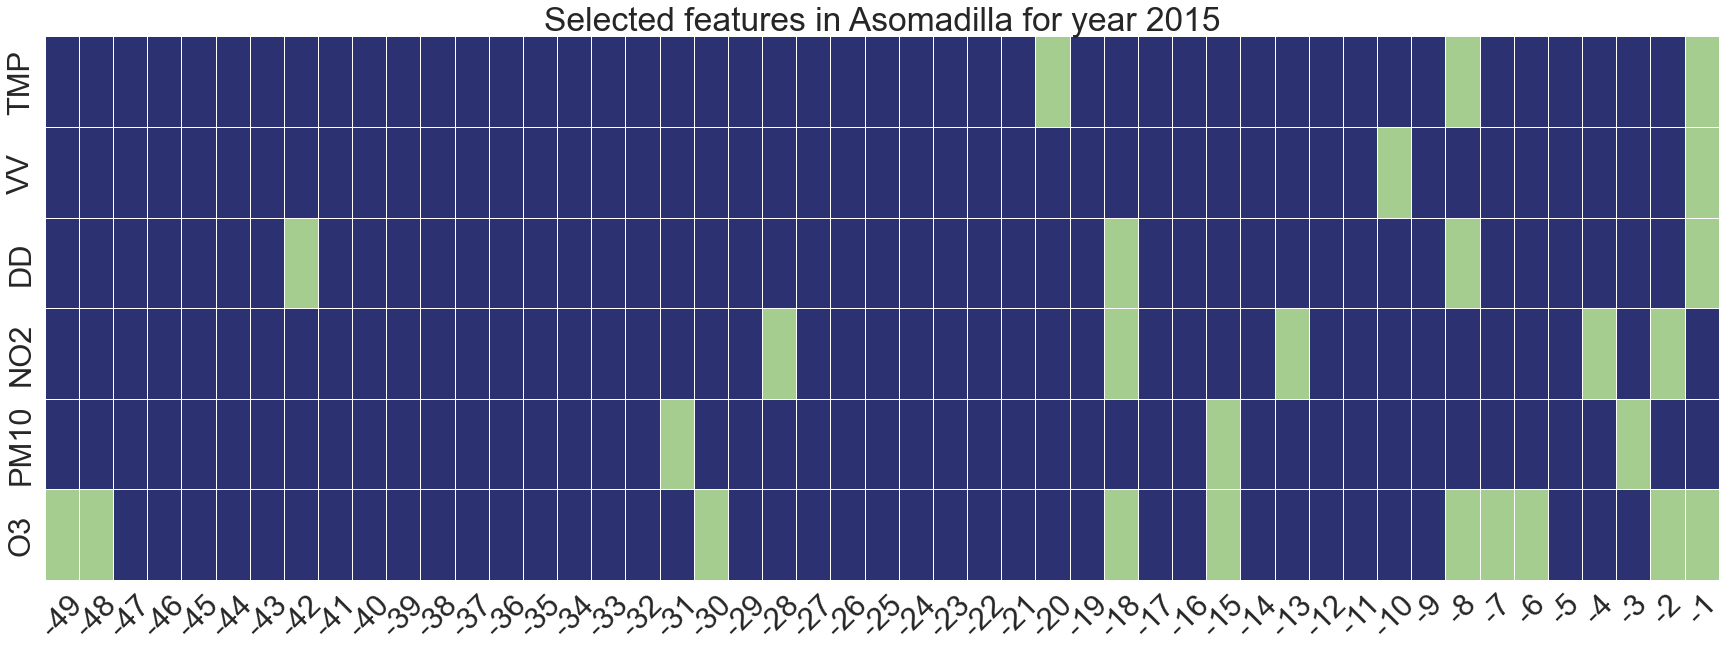

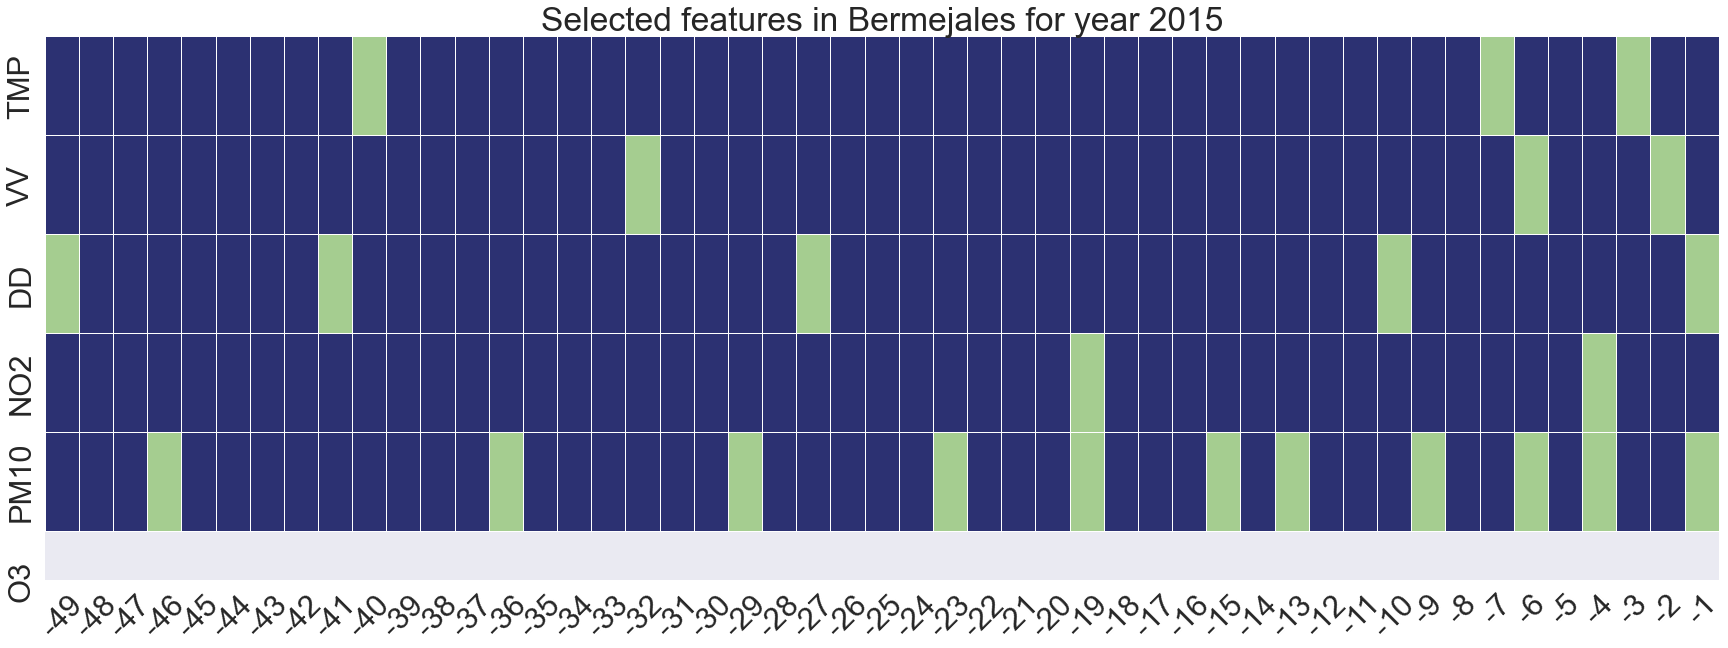

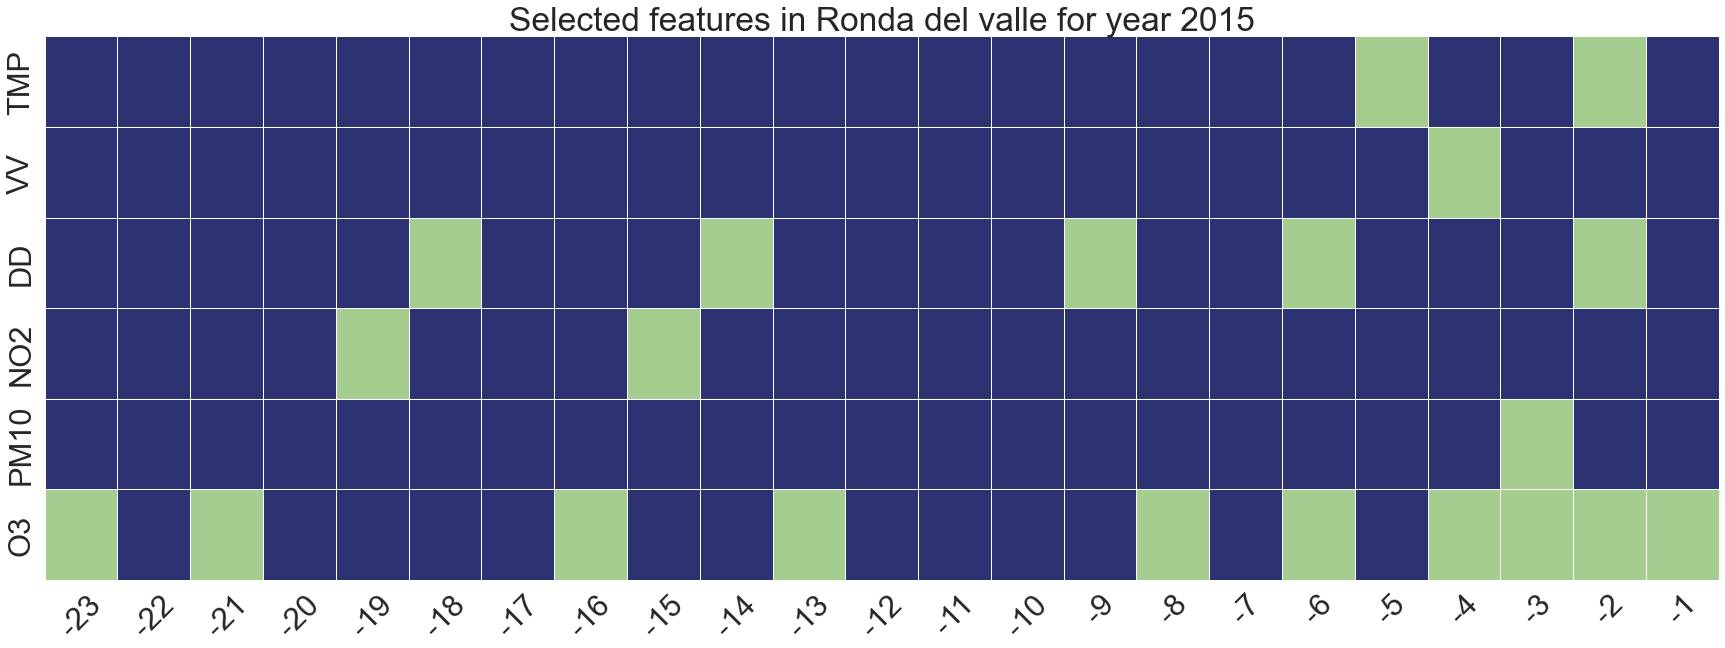

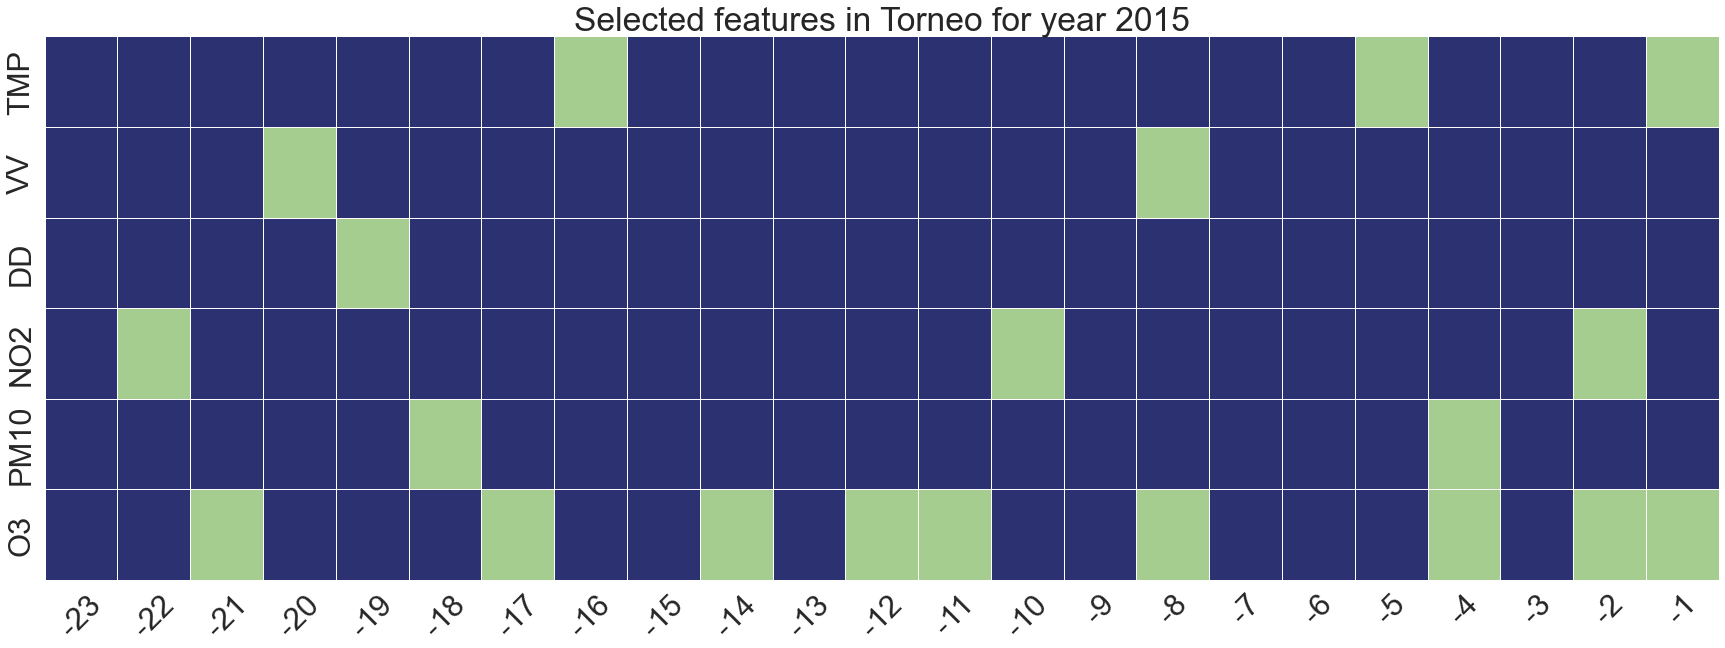

In [11]:
sns.set(font_scale=2.8)
best_by_year_selected = best_by_year[best_by_year.dataset_params_test_year>2005]

fetures_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_by_year_selected.dataset.unique():
    results_tsl_dataset = best_by_year_selected[(best_by_year_selected.dataset==dataset) & (best_by_year_selected.model_name=='TSL')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_by_year_selected[best_by_year_selected['dataset_params_test_year']==2015]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset} for year 2015')
    cmap = sns.cm.crest_r
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

## Results by year

In [6]:

best_metrics = total_metrics_indexed.loc[best_index].reset_index()
best_metrics = best_metrics.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False).mean().reset_index()
best_metrics = best_metrics.rename({'dataset_params_test_year': 'year'}, axis=1)
best_metrics = best_metrics[(best_metrics.year>2005)]
best_metrics.pivot(index = ['year'], columns=[ 'dataset','model_name'], values='root_mean_squared_error')#.round(1).to_latex()

/tmp/ipykernel_92963/2099734244.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  best_metrics = best_metrics.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False).mean().reset_index()


dataset    Ronda del valle                   Torneo                  
model_name              DT    FF    L1   TSL     DT    FF    L1   TSL
year                                                                 
2006                  21.2  20.3  20.1  19.8   14.3  13.9  13.1  13.5
2007                  19.7  19.5  19.5  20.1   14.2  13.9  13.2  13.5
2008                  20.6  20.6  20.5  20.3   14.4  14.2  13.5  13.8
2009                  20.0  19.1  18.9  19.2   14.7  14.5  13.6  14.1
2010                  21.5  20.3  21.1  19.5   14.7  15.0  14.4  15.3
2011                  18.6  19.1  18.4  18.5   14.7  14.5  14.2  14.3
2012                  16.8  16.8  16.0  16.0   15.3  14.8  14.4  14.6
2013                  18.3  17.2  17.4  16.8   15.0  14.4  13.6  14.7
2014                  18.7  17.7  17.9  18.4   14.5  14.4  13.9  14.3
2015                  17.9  17.5  17.6  17.6   15.2  14.6  14.4  14.2

## Bayesian tests

Aljarafe
(0.05076777275790345, 0.12935638999146104, 0.8198758372506355)
Asomadilla
(0.602895547675582, 0.10875292478995702, 0.288351527534461)
Bermejales
(0.03313082773446413, 0.12024413473288698, 0.8466250375326488)
Ronda del valle
(0.211954572140984, 0.23879189133067558, 0.5492535365283404)
Torneo
(0.9474553885433044, 0.044262588874285025, 0.00828202258241062)


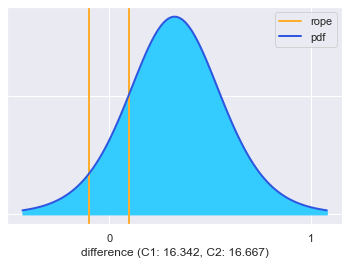

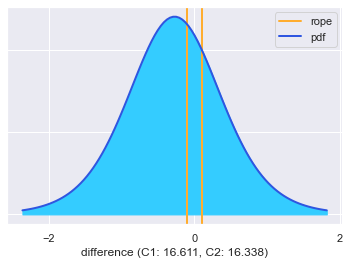

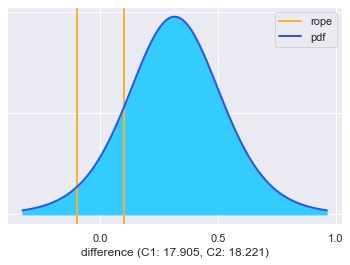

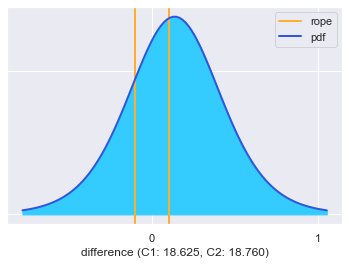

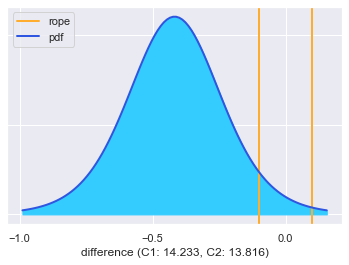

In [64]:
from baycomp import two_on_single


for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TSL')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, rope=0.1, plot=True)

    print(probs)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [18]:
best_hyperparameters = best_index.to_frame()[['dataset', 'model_name']].reset_index(drop=True)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)

In [20]:
pd.set_option('display.max_colwidth', 2000)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)
params = list(map(lambda my_dict: {k: my_dict[k]for k in my_dict if not isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_dropout', 'model_params_max_depth', 'model_params_regularization', 'selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = seq_lens
best_hyperparameters['params'] = params

best_hyperparameters.set_index(['dataset', 'model_name'])#.to_latex('tab.tex')

window  \
dataset         model_name           
Aljarafe        DT            24.0   
                FF            58.0   
                L1            58.0   
                TSL           38.0   
                TSL           24.0   
Asomadilla      DT            58.0   
                FF            58.0   
                L1            38.0   
                TSL           24.0   
                TSL           58.0   
Bermejales      DT            58.0   
                FF            38.0   
                L1            23.0   
                TSL            7.0   
                TSL            7.0   
Ronda del valle DT            17.0   
                FF            23.0   
                L1             7.0   
                TSL            7.0   
                TSL           17.0   
Torneo          DT             NaN   
                FF             NaN   
                L1             NaN   
                TSL            NaN   
                TSL            NaN   

                                                                                                                                                                                 params  
dataset         model_name                                                                                                                                                               
Aljarafe        DT                                                                                                                                      {'model_params_max_depth': 5.0}  
                FF                                                                  {'model_params_layers': 1.0, 'model_params_units': 6.0, 'model_params_dropout': 0.1058140580000295}  
                L1                                                                                                                  {'model_params_regularization': 0.0001143748173448}  
                TSL          {'model_params_layers': 2.0, 'model_params_units': 47.0, 'model_params_dropout': 0.163322450886048, 'selection_params_regularization': 0.0088594323988978}  
                TSL          {'model_params_layers': 2.0, 'model_params_units': 47.0, 'model_params_dropout': 0.163322450886048, 'selection_params_regularization': 0.0088594221336867}  
Asomadilla      DT                                                                                                                                      {'model_params_max_depth': 4.0}  
                FF                                                                  {'model_params_layers': 2.0, 'model_params_units': 49.0, 'model_params_dropout': 0.331720748909224}  
                L1                                                                                                                  {'model_params_regularization': 0.0273875931979261}  
                TSL           {'model_params_layers': 1.0, 'model_params_units': 37.0, 'model_params_dropout': 0.049173416916525, 'selection_params_regularization': 0.009578899512552}  
                TSL          {'model_params_layers': 2.0, 'model_params_units': 16.0, 'model_params_dropout': 0.4416530456029049, 'selection_params_regularization': 0.007509426830849}  
Bermejales      DT                                                                                                                                      {'model_params_max_depth': 5.0}  
                FF                                                                  {'model_params_layers': 2.0, 'model_params_units': 18.0, 'model_params_dropout': 0.208511002351287}  
                L1                                                                                                                  {'model_params_regularization': 0.0001143748173448}  
                TSL           {'model_params_layers': 1.0, 'model_params_units': 37.0, 'model_params_dropout': 0.049173416916525, 'selection_params_regularization': 0.009578899512552}  
                TSL      